In [411]:
import pandas as pd
import numpy as np
import matplotlib 

matplotlib.use('Agg') 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
%matplotlib inline

import os
from riak import RiakClient
from riak.transports.pbc.codec import RiakPbcCodec
from datetime import datetime
from datetime import timedelta
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from urllib import urlretrieve 

# You might want to change this Riak settings to match your environment. 
RIAK_HOST = '127.0.0.1'
RIAK_PB_PORT = '10017'
RIAK_ADMIN = '/usr/local/riak/bin/riak-admin'

SENSOR_TABLE = 'sensor29'
GAMES_TABLE = 'games2'
DATA_DIR = "data"
EVENTS = "Dodgers.events"
TRAFFIC = "Dodgers.data"
EVENTS_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/event-detection/Dodgers.events"
TRAFFIC_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/event-detection/Dodgers.data"

# Load dataset

In [382]:
urlretrieve(EVENTS_URL, os.path.join(DATA_DIR, EVENTS))
urlretrieve(TRAFFIC_URL, os.path.join(DATA_DIR, TRAFFIC))

('data/Dodgers.data', <httplib.HTTPMessage instance at 0x11e023cf8>)

In [383]:
traffic_raw = pd.read_csv(os.path.join(DATA_DIR, TRAFFIC), 
                          header=None, 
                          names=['daytime', 'count'], 
                          na_values=['-1'],
                          parse_dates=[0])
events_raw = pd.read_csv(os.path.join(DATA_DIR, EVENTS), 
                         header=None, 
                         usecols=[0,1,2,3,4],
                         names=['date', 'begin', 'end', 'attendance', 'away_team'],
                         parse_dates=[[0,1], [0,2]])

In [384]:
events_raw['home_team'] = 'Dodgers'
events_raw['city'] = 'LA'
events_raw.head()

,date_begin,date_end,attendance,away_team,home_team,city
0,2005-04-12 13:10:00,2005-04-12 16:23:00,55892,San Francisco,Dodgers,LA
1,2005-04-13 19:10:00,2005-04-13 21:48:00,46514,San Francisco,Dodgers,LA
2,2005-04-15 19:40:00,2005-04-15 21:48:00,51816,San Diego,Dodgers,LA
3,2005-04-16 19:10:00,2005-04-16 21:52:00,54704,San Diego,Dodgers,LA
4,2005-04-17 13:10:00,2005-04-17 15:31:00,53402,San Diego,Dodgers,LA


## Drop NA values

In [385]:
traffic_df = traffic_raw.dropna().copy()
traffic_df['ramp'] = '101 North freeway'
traffic_df['city'] = 'LA'
traffic_df.head()

,daytime,count,ramp,city
379,2005-04-11 07:35:00,23,101 North freeway,LA
380,2005-04-11 07:40:00,42,101 North freeway,LA
381,2005-04-11 07:45:00,37,101 North freeway,LA
382,2005-04-11 07:50:00,24,101 North freeway,LA
383,2005-04-11 07:55:00,39,101 North freeway,LA


## Create Riak buckets

In [407]:
rc = RiakClient(host=RIAK_HOST, pb_port=RIAK_PB_PORT, protocol='pbc')
rc.ping()

True

In [409]:
os.system('{riak_admin} bucket-type create {table} `cat sensorData.json`'.format(riak_admin=RIAK_ADMIN, 
                                                                                 table=SENSOR_TABLE))
os.system('{riak_admin} bucket-type activate {table}'.format(riak_admin=RIAK_ADMIN, 
                                                             table=SENSOR_TABLE))

0

Alternatively you can directly use the Create statement command
fmt = """CREATE TABLE {table} (
            ramp varchar not null,
            city varchar not null,
            daytime timestamp not null,
            count double,
            PRIMARY KEY((ramp, city, quantum(daytime, 60, d)), ramp, city, daytime))
        """
query = fmt.format(table=SENSOR_TABLE)
ts_obj = rc.ts_query(table,query)


fmt = """CREATE TABLE {table} (
            home_team varchar not null,
            city varchar not null,
            date_begin timestamp not null,
            date_end timestamp not null,
            attendance sint64,
            away_team varchar,
            PRIMARY KEY((home_team, city, quantum(date_begin, 60, d)), home_team, city, date_begin))
        """
query = fmt.format(table=GAMES_TABLE)
ts_obj = rc.ts_query(table,query)

In [410]:
os.system('{riak_admin} bucket-type create {table} `cat games.json`'.format(riak_admin=RIAK_ADMIN,
                                                                            table=GAMES_TABLE))
os.system('{riak_admin} bucket-type activate {table}'.format(riak_admin=RIAK_ADMIN,
                                                             table=GAMES_TABLE))

0

## Put dataset in Riak

In [29]:
table = rc.table(GAMES_TABLE)
ts_obj = table.new(events_raw.values.tolist())
result = ts_obj.store()

In [17]:
table = rc.table(SENSOR_TABLE)
ts_obj = table.new(traffic_df.values.tolist())
result = ts_obj.store()

## Exploratory analysis

### Let's find out how games are related to traffic

First we need to get understanding of the dataset. Let's plot the game intervals on top of the traffic data

In [389]:
codec = RiakPbcCodec()
start = datetime.strptime('2005-04-01', '%Y-%m-%d')
end = datetime.strptime('2005-04-20', '%Y-%m-%d')
query = "select daytime, count from {table} where daytime > {t1} and daytime < {t2} \
            and ramp = '101 North freeway' and city='LA'".format(table=SENSOR_TABLE, 
                                                                 t1=codec._unix_time_millis(start),
                                                                 t2=codec._unix_time_millis(end))
traff = rc.ts_query(SENSOR_TABLE, query)
april_traffic = np.array(traff.rows)
april_traffic.shape

(2485, 2)

In [391]:
query = "select date_begin, date_end, attendance from {table} where date_begin > {t1} \
            and date_begin < {t2} and home_team  = 'Dodgers' and city='LA'".format(table=GAMES_TABLE, 
                                                                                   t1=codec._unix_time_millis(start),
                                                                                   t2=codec._unix_time_millis(end))
games = rc.ts_query(GAMES_TABLE, query)
april_games = np.array(games.rows)
april_games.shape

(5, 3)

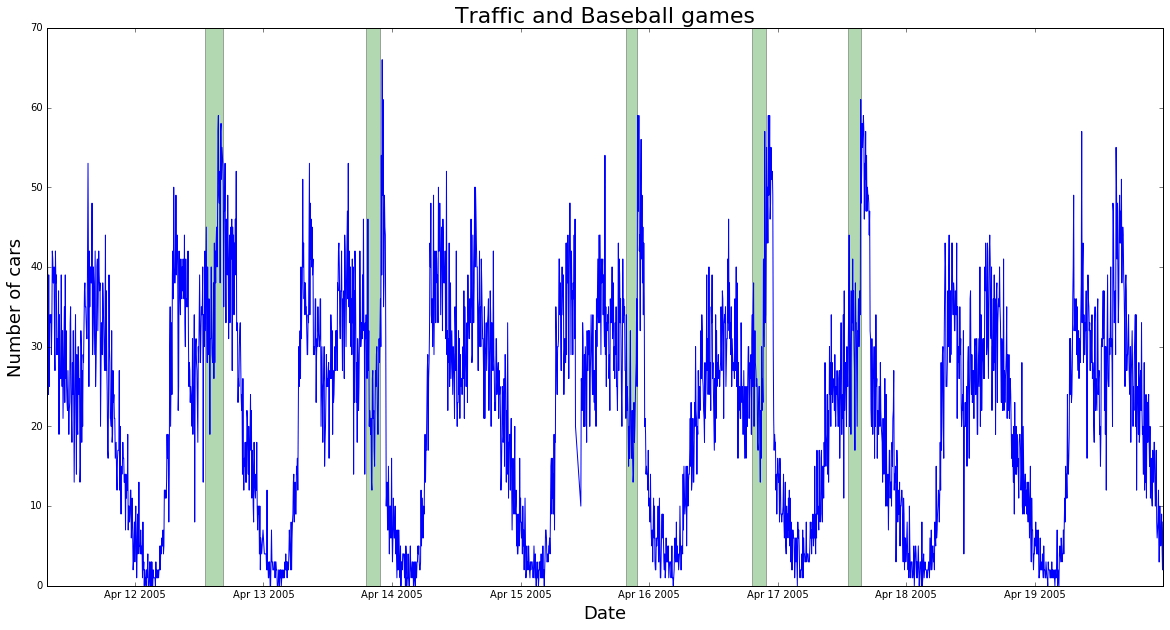

In [392]:
plt.figure(figsize=(20,10))
for game in april_games:
    plt.gca().axvspan(game[0],game[1], facecolor='green',alpha=0.3)
plt.plot(april_traffic[:,0], april_traffic[:,1])
plt.title("Traffic and Baseball games", fontsize=22)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number of cars', fontsize=18)

We can see that traffic peaks are following game events, but data is quite noisy. We can smooth it with the moving average filter.

### Smooth the time series to get rid of noise

In [393]:
def chunker(seq, win, step, dropend=True):
    if (dropend):
        return (seq[pos:pos + win] for pos in xrange(0, len(seq), step) if len(seq) - pos >= win)
    else:
        return (seq[pos:pos + win] for pos in xrange(0, len(seq), step))

In [394]:
interval = 12  # one hour
april_mean_traffic = np.array([])
for i, chunk in enumerate(chunker(april_traffic[:,1].astype(np.float), interval, 1, False)):
    april_mean_traffic = np.append(april_mean_traffic, np.mean(chunk))

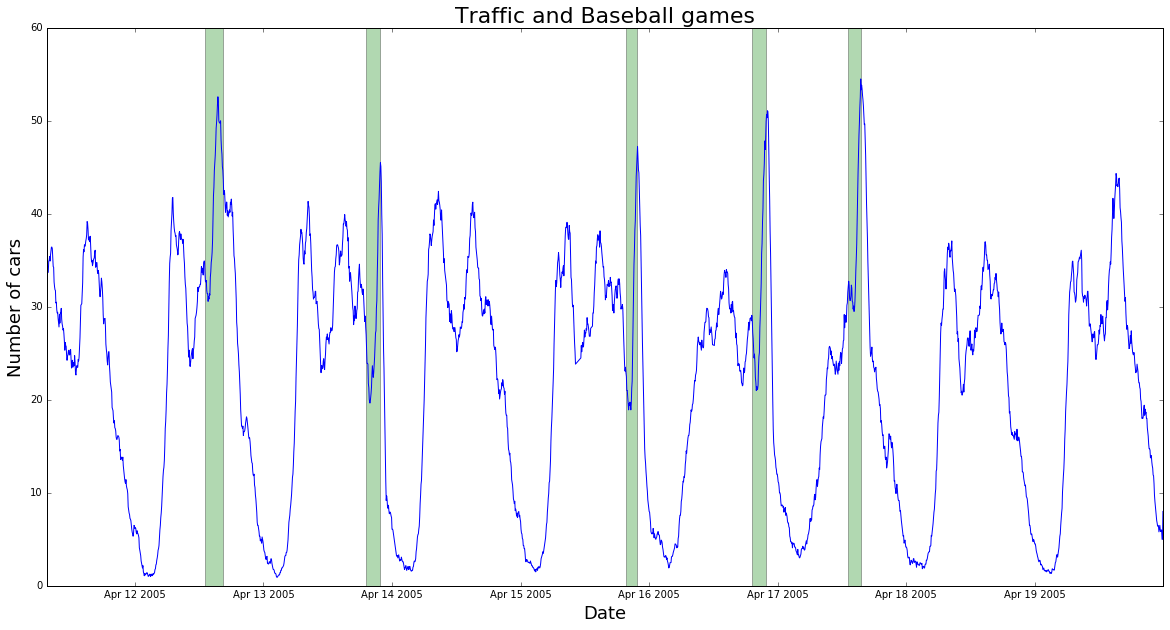

In [395]:
plt.figure(figsize=(20,10))
for game in april_games:
    plt.gca().axvspan(game[0],game[1], facecolor='green',alpha=0.3)
plt.plot(april_traffic[:,0], april_mean_traffic)
plt.title("Traffic and Baseball games", fontsize=22)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number of cars', fontsize=18)

## Modeling

### Query all data from Riak

In [396]:
end = datetime.strptime('2005-10-01', '%Y-%m-%d')
query = "select daytime, count from {table} where daytime > {t1} and daytime < {t2} \
            and ramp = '101 North freeway' and city='LA'".format(table=SENSOR_TABLE, 
                                                                 t1=codec._unix_time_millis(start),
                                                                 t2=codec._unix_time_millis(end))
traff = rc.ts_query(SENSOR_TABLE, query)
traffic_all = np.array(traff.rows)

query = "select date_begin, date_end, attendance from {table} where date_begin > {t1} \
            and date_begin < {t2} and home_team  = 'Dodgers' and city='LA'".format(table=GAMES_TABLE, 
                                                                                   t1=codec._unix_time_millis(start),
                                                                                   t2=codec._unix_time_millis(end))
games = rc.ts_query(GAMES_TABLE, query)
games_all = np.array(games.rows)

### Extract features

In [397]:
overlap = lambda a, b: max(0, (min(a[1], b[1]) - max(a[0], b[0])).total_seconds())
data = []
shift = timedelta(minutes=60)
for chunk in chunker(traffic_all, interval, 1):
    time = chunk[:,0]
    count = chunk[:,1].astype(np.float)
    mean = np.mean(count)
    max_v = np.max(count)
    min_v = np.min(count)
    std = np.std(count)
    median = np.median(count)
    label = any([overlap((time[0], time[-1]), (g[0] + shift, g[1] + shift)) > 0 for g in games_all])
    features = np.array([mean, max_v, min_v, std, median, label])
    data.append(np.array(features))
    
df = pd.DataFrame(data, columns=['mean', 'max', 'min', 'std', 'median', 'label'])
df.shape

(47484, 6)

### Rescale features into [0, 1] inerval and print summary statistics

In [398]:
df.iloc[:,0:5] -= df.iloc[:,0:5].min()
df.iloc[:,0:5] /= df.iloc[:,0:5].max()
df.describe()

,mean,max,min,std,median,label
count,47484.000000,47484.000000,47484.000000,47484.000000,47484.000000,47484.000000
mean,0.373484,0.329362,0.264655,0.162017,0.370278,0.073709
std,0.213595,0.166808,0.190794,0.078142,0.216624,0.261300
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.156250,0.166667,0.061224,0.105777,0.151786,0.000000
50%,0.416667,0.366667,0.285714,0.162109,0.410714,0.000000
75%,0.543155,0.466667,0.408163,0.206817,0.544643,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Randomly split on train and test

In [399]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:5], df['label'], test_size=0.2, random_state=333)

### Fit random forest classifier

In [400]:
model = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Calculate accuracy score

In [401]:
predictions = model.predict(X_test)
model.score(X_test, y_test)

0.94756238812256499